<h>Импорт библиотек</h>

In [132]:
! pip install pandas
! pip install tensorflow
! pip install seaborn
! pip install matplotlib
! pip install scikit-learn

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

print("complete")

complete


<h>Загрузка даных и создание модели</h>

In [127]:
# 1. Загрузка данных из CSV файла
data = pd.read_csv("100kcats_dataset.csv")

# Удалим столбец 'Name', так как он не несет информационной нагрузки для обучения модели
data.drop(columns=['Name'], inplace=True)

# Преобразование текстовых значений пород кошек в числовые индексы с помощью метода pd.factorize()
data['Breed'], breed_mapping = pd.factorize(data['Breed'])

# Создание словаря, где ключами будут числовые индексы, а значениями - соответствующие им текстовые значения пород кошек
breed_index_to_name = {index: breed for index, breed in enumerate(breed_mapping)}

# Разделение данных на признаки (X) и целевую переменную (y)
X = data.drop(columns=['Breed']).values
y = data['Breed'].values

# 2. Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Создание многослойного персептрона
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(10,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 выходных нейронов для 10 пород кошек
])

# Компиляция модели
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print('compiled')

compiled


<h>Обучение и его оптимизация</h>

In [128]:
# Определение колбэка EarlyStopping
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001, restore_best_weights=True)

# Обучение сети с использованием метода ранней остановки
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping_callback])

# Оценка производительности модели на тестовых данных
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', test_accuracy)

Epoch 1/100
1000/1000 [==============================] - 4s 3ms/step - loss: 0.2654 - accuracy: 0.9224 - val_loss: 0.0622 - val_accuracy: 0.9777
Epoch 2/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0658 - accuracy: 0.9752 - val_loss: 0.0508 - val_accuracy: 0.9808
Epoch 3/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0570 - accuracy: 0.9781 - val_loss: 0.0604 - val_accuracy: 0.9771
Epoch 4/100
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0505 - accuracy: 0.9801 - val_loss: 0.0593 - val_accuracy: 0.9756
Epoch 5/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0469 - accuracy: 0.9815 - val_loss: 0.0502 - val_accuracy: 0.9814
Epoch 6/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0427 - accuracy: 0.9829 - val_loss: 0.0332 - val_accuracy: 0.9868
Epoch 7/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0409 - accuracy: 0.9838 - val_loss: 0.0448 - val_ac

<h>Performance plot</h>

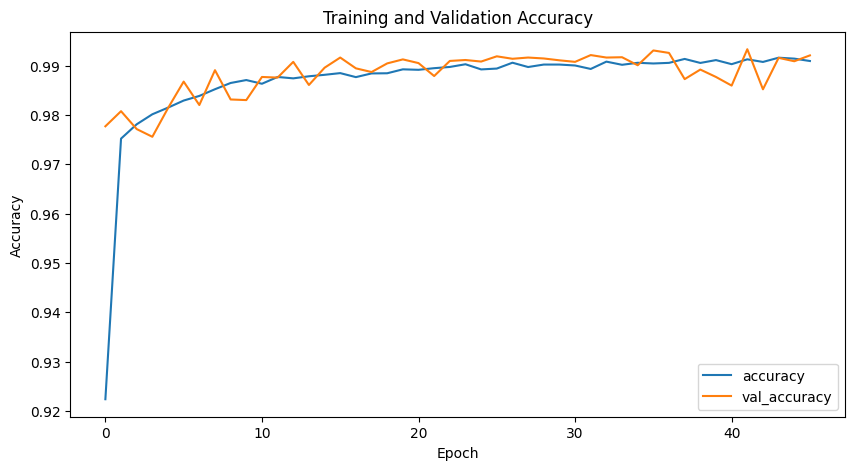

In [129]:
# Визуализация кривой обучения (learning curve)
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

<h>Ошибки и точность</h>

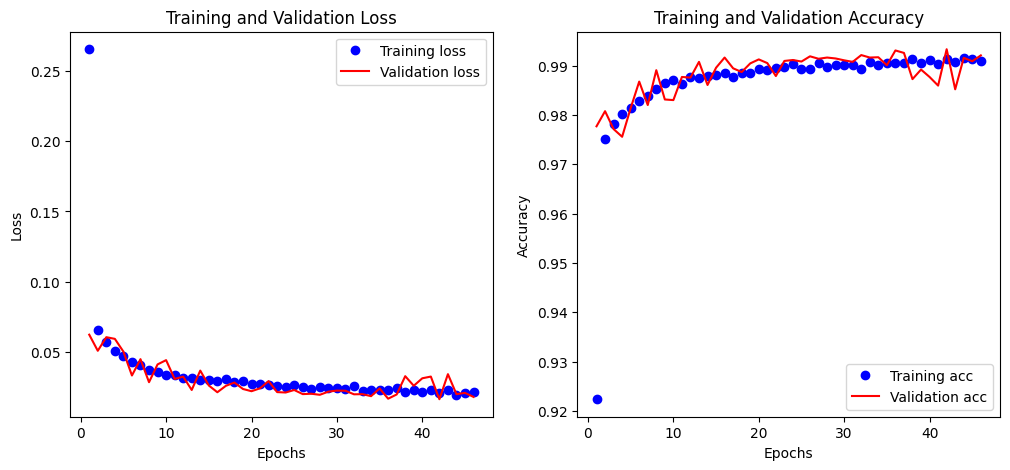

In [130]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Визуализация кривых обучения
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# Кривые функции потерь
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Кривые точности
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Функции для тестирования

In [173]:
def test_net(X_new,test_data):
  predictions = model.predict(X_new)

  # Преобразование числовых предсказаний в текстовые значения пород кошек с использованием соответствия
  predicted_breeds_index = [np.argmax(prediction) for prediction in predictions]
  predicted_breeds = [breed_index_to_name[index] for index in predicted_breeds_index]

  # Создание DataFrame с характеристиками кошек и предсказанными породами
  predicted_data = pd.DataFrame(X_new, columns=data.columns[1:])
  predicted_data['Predicted Breed'] = predicted_breeds

  col_c = predicted_data.pop('Predicted Breed')  # Удаление столбца 'C' и возврат его как Series
  predicted_data.insert(0, 'Predicted Breed', col_c)  # Вставка Series обратно в датафрейм на позицию 0

  # Загрузка истинных меток пород кошек из тестового набора данных
  true_breeds = test_data['Breed'].values

  # Вывод матрицы ошибок с текстовыми представлениями классов
  class_names = test_data['Breed'].unique()  # Уникальные классы (породы кошек)
  conf_matrix = confusion_matrix(true_breeds, predicted_breeds)

  # Создание DataFrame для матрицы ошибок
  conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

  accuracy = accuracy_score(true_breeds, predicted_breeds)

  print(f"Confusion Matrix (Accuracy = {accuracy}):")
  return predicted_breeds

In [184]:
def conf_matrix(test_data, predicted_breeds):
  true_breeds = test_data['Breed'].values

   # Вывод матрицы ошибок с текстовыми представлениями классов
  class_names = test_data['Breed'].unique()  # Уникальные классы (породы кошек)
  conf_matrix = confusion_matrix(true_breeds, predicted_breeds)

  # Создание DataFrame для матрицы ошибок
  conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

  # Визуализация матрицы ошибок с помощью seaborn heatmap
  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix_df, annot=True, cmap="Greens", fmt='.0f')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.xticks(rotation=45)
  plt.yticks(rotation=0)
  plt.show()

<h>Тестирование гигантского набора и матрица ошибки</h>

313/313 [==============================] - 1s 1ms/step
Confusion Matrix (Accuracy = 0.9923):


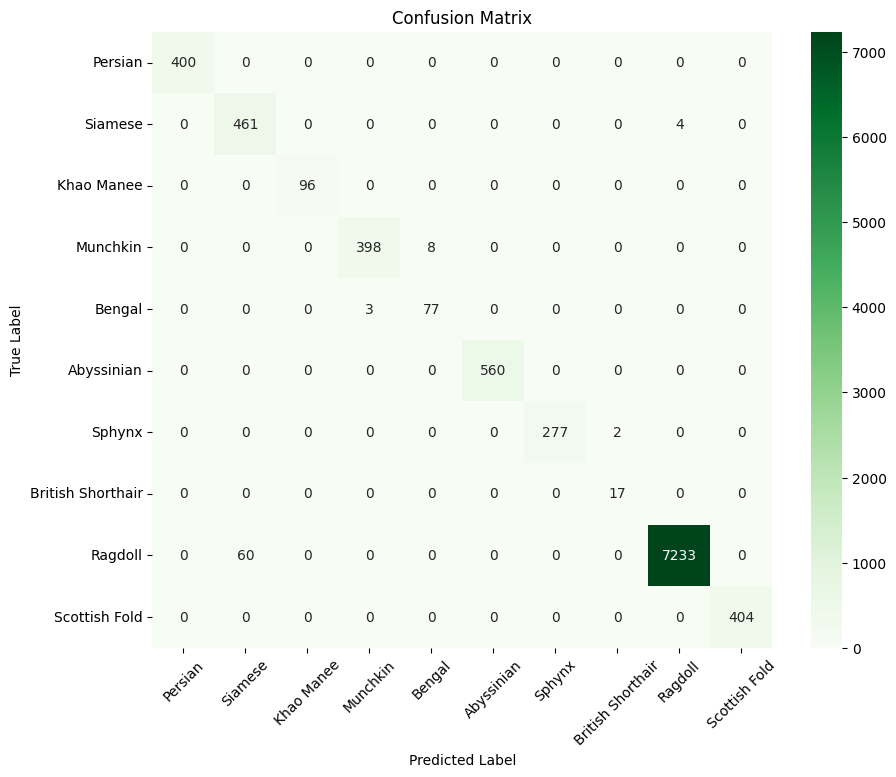

In [185]:
test_data = pd.read_csv("cats_dataset.csv")
X_new = test_data.drop(columns=['Breed','Name']).values
conf_matrix(test_data, test_net(X_new, test_data))

<h>Тестирование маленького набора и матрица ошибки</h>

1/1 [==============================] - 0s 24ms/step
Confusion Matrix (Accuracy = 1.0):


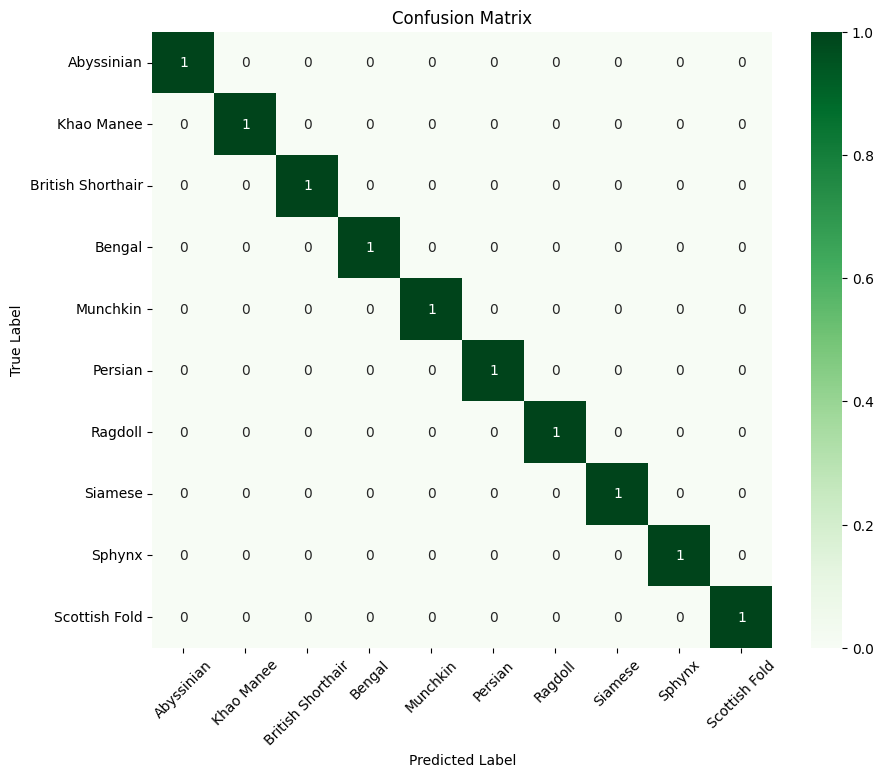

In [186]:
test_data = pd.read_csv("test_dataset.csv")
X_new = test_data.drop(columns=['Breed','Name']).values
conf_matrix(test_data, test_net(X_new, test_data))

<h>Тестирование большого набора и матрица ошибки</h>

32/32 [==============================] - 0s 2ms/step
Confusion Matrix (Accuracy = 0.987):


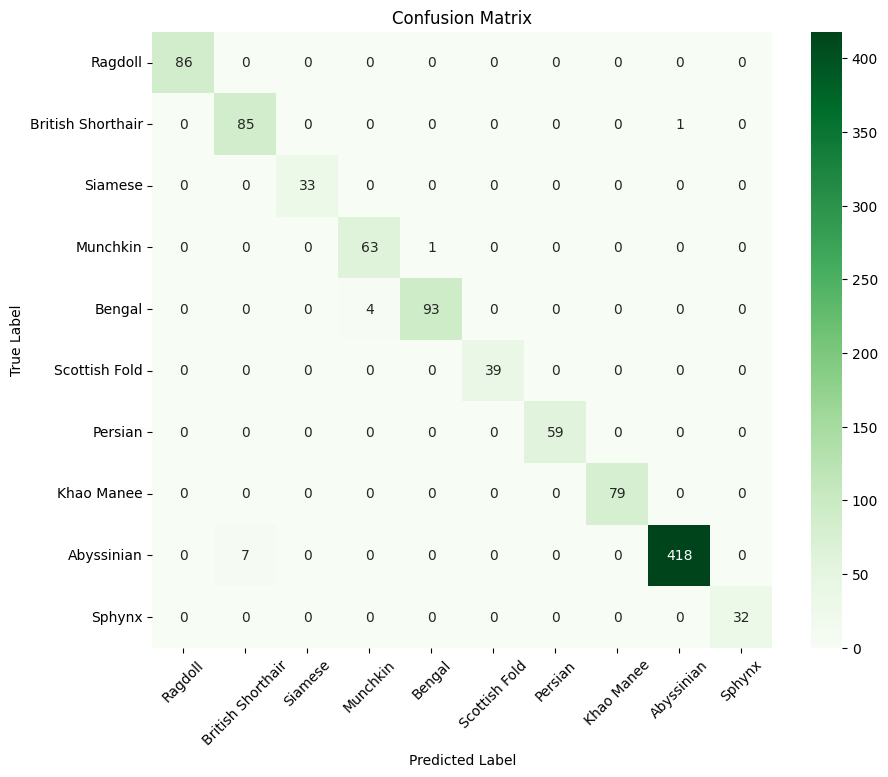

In [187]:
test_data = pd.read_csv("big_test_dataset.csv")
X_new = test_data.drop(columns=['Breed','Name']).values
conf_matrix(test_data, test_net(X_new, test_data))

<h>Факторы обучения</h>

Количество эпох обучения: Изменение количества эпох обучения может повлиять на то, насколько хорошо модель сходится к оптимальному решению. Слишком маленькое количество эпох может привести к недообучению, а слишком большое - к переобучению.

Размер пакета (batch size): Размер пакета определяет, сколько примеров данных обрабатывается за одну итерацию обучения. Большие размеры пакета могут ускорить обучение, но могут также привести к ухудшению обобщающей способности модели.

Структура сети (количество слоев и нейронов): Изменение структуры сети, такое как количество слоев и нейронов, может влиять на её способность обучаться и обобщать. Более сложные модели могут иметь большую емкость для изучения сложных паттернов, но при этом могут быть более склонны к переобучению.

Функции активации: Выбор различных функций активации для скрытых слоев сети (например, ReLU, Sigmoid, Tanh) также может повлиять на обучение и производительность модели.

Скорость обучения (learning rate): Этот параметр определяет, насколько быстро веса модели обновляются во время обучения. Слишком высокая скорость обучения может привести к расходимости, а слишком низкая - к медленной сходимости.

Метод регуляризации: Использование методов регуляризации, таких как Dropout или L2 регуляризация, может помочь в борьбе с переобучением.